# Lab 5: Non-negative Matrix Factorization

The goal of this lab session is to code a NMF algorithm and use it in some applications.

You have to send the filled notebook named **"NMF_familyname1_familyname2.ipynb"** (groups of 2) by email to *aml.centralesupelec.2020@gmail.com* a week from now and put **"NMF Lab"** in the subject. 

All questions will be graded unless it is explicitely indicated.

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import check_random_state
import math

%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

*Remark:* In this notebook, we do not plot every image when there are several hundreds. Indeed, we intend to keep the file's size reasonably low.

## NMF

Loss (Regularized Froebnius): $\mathcal{L}(D, S) = \frac{1}{2}\|X-D S\|_{F}^{2}+ \color{red}{\frac{\mu}{2}\|S\|_{F}^{2}+\lambda\|S\|_{1}+\frac{\nu}{2}\|D\|_{F}^{2}}$

Algorithm (multiplicative updates from [Lee and Seung, 1999]: 

\begin{array}{c}
D \leftarrow D \circ \frac{X S^{\top}}{D (S S^{\top} + {\color{red} \nu I_r})} \\
S \leftarrow S \circ \frac{D^{\top} X - {\color{red} \lambda 1_{r \times n}}}{(D^{\top} D + {\color{red} \mu I_r})S}
\end{array}

Fill in the following NMF class:

In [2]:
class MYNMF():
    
    def __init__(self, n_components, random_state=42, max_iter=200, eps=.1):
        self.n_components_ = n_components
        self.max_iter_ = max_iter
        self.components_ = None    # shape (r, p)
        self.random_state = random_state
        self.eps = eps
        self.loss_hist_ = []
        
    def fit_transform(self, data, mu=1., lambda_=1., nu=1.):
        """ Find the parameters mu_ and Sigma_
        that better fit the data
        
        Parameters:
        -----------
        data: (n, p) np.array
               Data matrix
        
        Returns:
        -----
        embedding: (r,n) np.array
                    Embedding matrix        
        """        
        # TODO:
        # initialize both matrices
        
        # While not(convergence):
        #     Update D
        #     Update S
        
        # Return the embedding S
        
        # Initializing D, S with random, positive coefficients
        r = self.n_components_
        rng = np.random.default_rng(self.random_state)
        # Note that rng.random will generate 0 with probability 0, therefore D and S will be positive with probability 1
        embedding, self.components_ = rng.random((r,data.shape[0])), rng.random((data.shape[1],r))
        
        # Transpose data matrix into shape (p,n)
        X = data.T
        
        # Loop until convergence
        converge,iter_ = False,0
        while not converge and iter_ < self.max_iter_:
            D,S = self.components_, embedding
            
            D_numerator = np.matmul(X, embedding.T)
            D_denominator = np.matmul(self.components_, np.matmul(embedding,embedding.T) + nu*np.identity(r))
            self.components_ = np.multiply(self.components_,np.divide(D_numerator,D_denominator))
            
            S_numerator = np.matmul(self.components_.T,X) - lambda_*np.ones((r,X.shape[1]))
            S_denominator = np.matmul(np.matmul(self.components_.T,self.components_) + mu*np.identity(r),embedding)
            embedding = np.multiply(embedding,np.divide(S_numerator,S_denominator))
            
            # Test for convergence:
            if np.linalg.norm(np.matmul(D,S) - np.matmul(self.components_, embedding)) < self.eps:
                converge = True
                
            # Computing mean squared error loss with regularizers
            loss = np.linalg.norm(np.matmul(self.components_,embedding) - X, ord='fro')**2 / 2 + mu * np.linalg.norm(embedding, ord='fro')**2 / 2 + nu * np.linalg.norm(self.components_, ord='fro')**2 / 2 + lambda_ * np.linalg.norm(embedding, ord=1)
            self.loss_hist_.append(loss)
                
            iter_ += 1
        
        return embedding  
    
    
    def inverse_transform(self, embedding):
        """ Maps an embedding matrix into the original space. 
        
        Parameters:
        -----------
        embedding : (r,n) np.array
                     Embedding matrix
        
        Returns:
        -----
        data_hat : (p,n) np.array  
                   reconstructed data matrix
        """       
        data_hat = np.matmul(self.components_, embedding)

        return data_hat

    
    def predict_label(self, X):
        """ Predict labels for X : cluster hard-assignment
        
        Parameters:
        -----------
        X: (p,n) np.array
           data matrix
        
        Returns:
        -----
        label assignment : (n, ) np.array
                          Its elements are the predicted classes, from 0 to r-1
        """
        # Apply feature embedding matrix to data
        pred = np.matmul(np.linalg.pinv(self.components_),X)
        # Label is coefficient with maximal value
        labels = np.argmax(pred, axis=0)
        
        return labels
        
        
    def predict_proba(self, X):
        """ Predict probabilities of different classes for X :  cluster soft-assignment
        
        Parameters:
        -----------
        X: (p,n) np.array
            New data matrix
        
        Returns:
        -----
        label assignment : (r,n) np.array
                          Its elements are the probabilities for different classes
        """
        pred = np.matmul(np.linalg.pinv(self.components_),X)
        # Standardize each row by its sum
        proba = (pred - np.min(pred, axis=0)) / (np.max(pred, axis=0) - np.min(pred, axis=0))
        
        return proba

## Applications

### First application

For the first application you are going to analyse the following data to give an interpretation of the factorization:

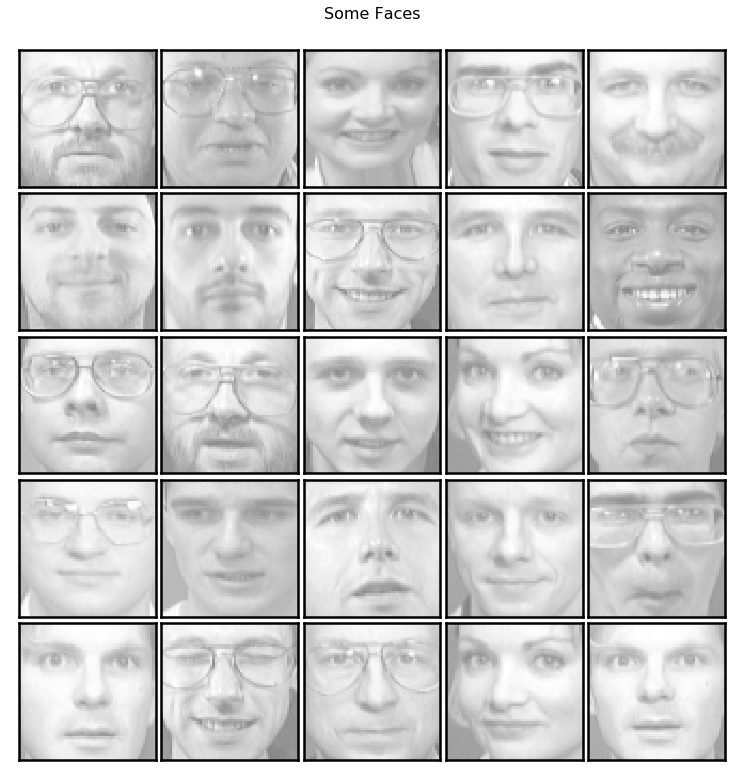

In [3]:
from sklearn.datasets import fetch_olivetti_faces


dataset = fetch_olivetti_faces(shuffle=True)

faces = dataset.data  # n = 400 flattened images of p = 4096 = 64 x 64
image_shape = (64, 64)

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

def plot_gallery(images, image_shape, title='', cmap=plt.cm.gray):
    
    # fit the nb of images into a square
    n_images = len(images)
    nrows = int(np.ceil(np.sqrt(n_images)))
    ncols = nrows
    
    # instantiate figure
    fig, axes = plt.subplots(nrows, ncols, figsize=(2. * ncols, 2.26 * nrows))
    fig.suptitle(title, size=16)
    
    axes_for_display = axes.flatten()[:n_images]
    axes_to_blank = axes.flatten()[n_images:]
    
    for idx, comp in enumerate(images):
        ax = axes_for_display[idx]
        vmax = max(comp.max(), -comp.min())
        ax.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        ax.set(xticks=(),
               yticks=())
        
    for ax in axes_to_blank:
        ax.axis('off')

    fig.tight_layout()
    fig.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)  # insert space below the suptitle
    

plot_gallery(title="Some Faces", 
             images=faces[:25], 
             image_shape=image_shape)


In [4]:
faces.shape

(400, 4096)

In [5]:
np.max(faces), np.min(faces)

(1.0, 0.0)

In [6]:
faces.shape

(400, 4096)

In [7]:
mynmf = MYNMF(40**2)

In [8]:
embedding = mynmf.fit_transform(faces)

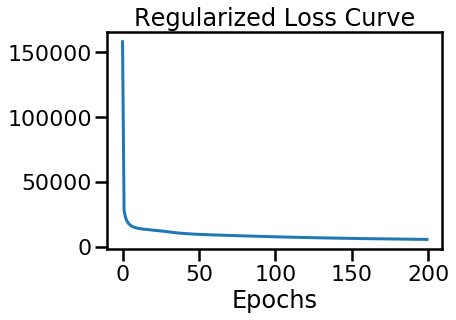

In [9]:
plt.title("Regularized Loss Curve")
plt.xlabel("Epochs")
plt.plot(mynmf.loss_hist_)
plt.show()

In [10]:
W_hat = np.matmul(mynmf.components_,embedding)
print(W_hat.shape)

(4096, 400)


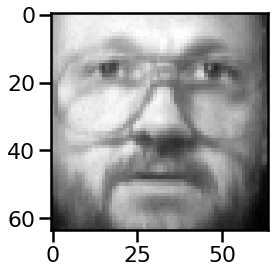

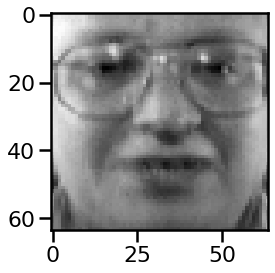

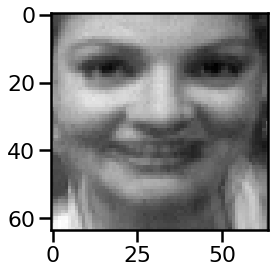

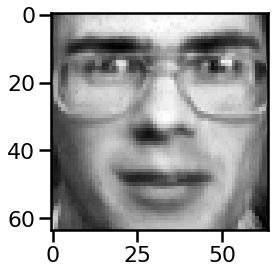

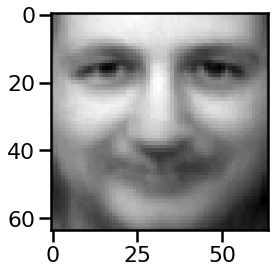

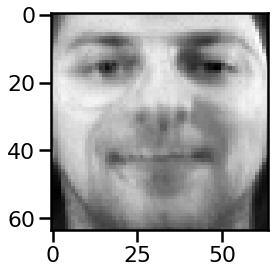

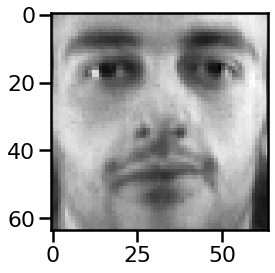

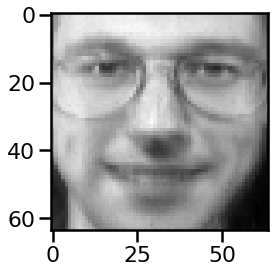

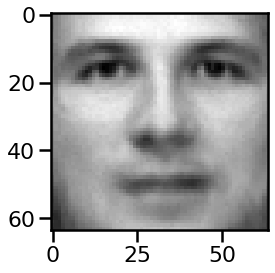

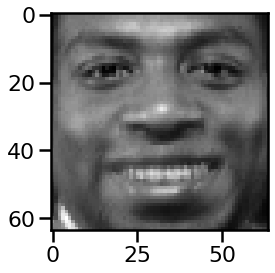

In [11]:
for i in range(10):
    plt.imshow(W_hat[:,i].reshape((64,64)), cmap='gray')
    plt.show()

Apply *your* NMF algorithm for this dataset and plot the approximated face pictures.

- Plot the $W$ matrix as images in a $(\sqrt{r}, \sqrt{r})$ grid
- Explain how to interpret both matrices W and H.
- Discuss the results you have obtained
- Conduct a critical analysis of your choice. Concretely, choose an aspect or two of the NMF method (e.g. Loss, Clustering, Geometry of the Embedding Space, Choice of the number of components r, any other of your choice), write code for it, test it, present (a) figure(s), and discuss. 

Let us first plot the rows of the components matrix $W$ in an $(\sqrt{r},\sqrt{r})$ grid.

In [12]:
W = mynmf.components_

In [13]:
W.shape

(4096, 1600)

In [14]:
sqrt_r = int(math.sqrt(mynmf.n_components_))
sqrt_r

40

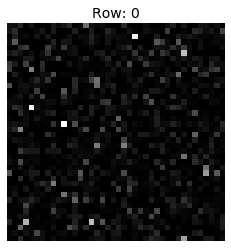

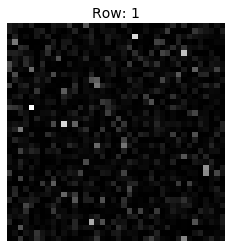

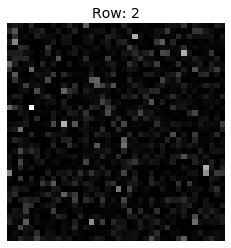

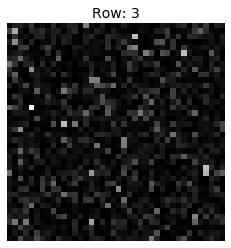

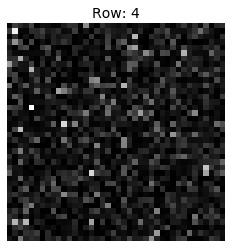

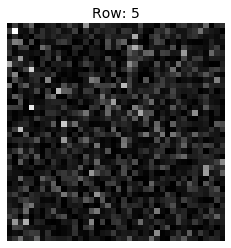

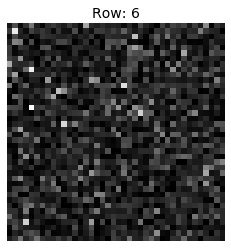

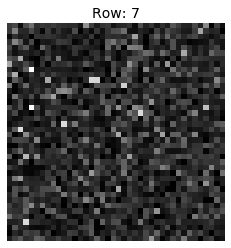

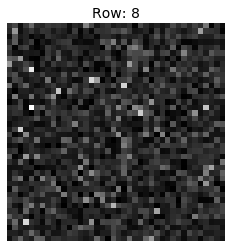

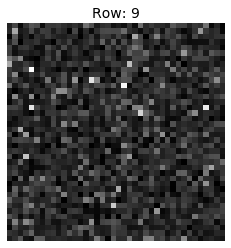

In [15]:
for i in range(10):
    row = W[i,:]
    # Reshape row into square image
    img = row.reshape((sqrt_r,sqrt_r))
    # Plot image in grayscale
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Row: {}'.format(i), fontsize=14)
    plt.show()

These images are difficultly interpretable but this is nevertheless expected. Indeed, our data is factorized as follows:
$$ X_{m,n} = W_{m,r}H_{r,n} $$ 
Where n is the number of images in our dataset and m the number of pixels per image. Each pixel represents a feature of our data.

The rows of W provide an embedding of our features in a space of dimension $r<m$. Therefore, it is expected that the attempt to visualize the embedding of a unique pixel as a 2D-image will fail to provide physically interpretable sense. \
However, we expect the columns of $W$ to provide a lower order basis (of size $r$) of our dataset. In our case, we would expect $r$ shapes of faces that best decompose the $m$ faces of our dataset.

Let us plot the columns of $W$ as images of size $(\sqrt{m},\sqrt{m})$:

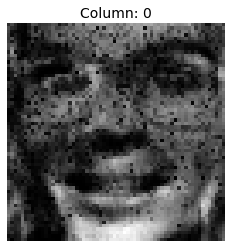

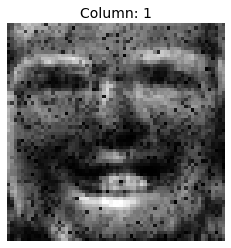

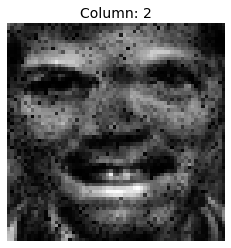

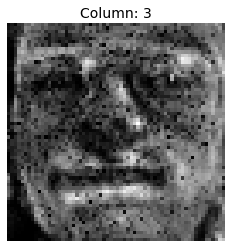

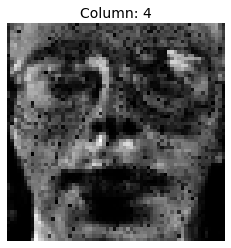

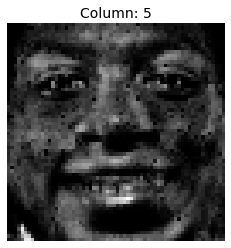

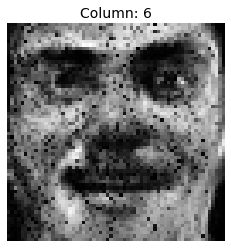

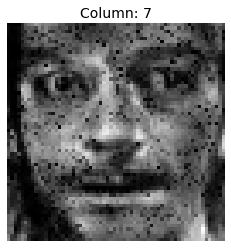

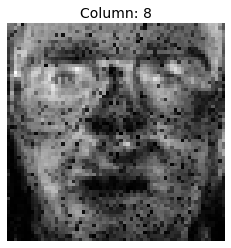

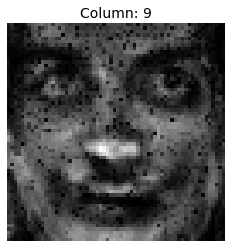

In [16]:
for i in range(10):
    feature = W[:,i]
    img = feature.reshape((int(math.sqrt(W.shape[0])),int(math.sqrt(W.shape[0]))))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Column: {}'.format(i), fontsize=14)
    plt.show()

As expected, each column represents a face. These faces can be interpreted as an approximation of the $r$ best faces that can be linearly combined to form the $m$ faces of our dataset.

$H$'s columns represent the coordinates of the faces of our dataset in the basis of the images embedded by $W$.

### Discussion on Model Parametrization

##### Choice of $r$

Several methods exist in order to compute the 'correct value' of $r$. The underlying idea of this problem being that we wish to compute the dimension $r$ of a space in which most of the information from our dataset is embedded.

- Cophenetic Coefficient *(Brunet et al. 2004)*

This method seeks to explore multiple values of $r$ and compute their cophenetic coefficient. According to Brunet et al., the correct value of $r$ is the value for which the coefficient starts decreasing.

"The cophenetic coefficient is a measure of how faithfully a dendrogram preserves between the originally unmodeled data points." Therefore, the idea of choosing the first $r$ for which the cophenetic coefficient decreases ensures that we keep the significant information in our compressed image.

We explore several values of $r$ (Note: this method is computationally heavy and requires time to run):

In [4]:
r_vals = np.square([1,20,28,36,44,52,64])

In [9]:
# Train model for values of r in r_vals
w_hat_list = []

for r in r_vals:
    mynmf = MYNMF(r)
    embedding = mynmf.fit_transform(faces)
    w_hat_list.append(np.matmul(mynmf.components_,embedding))
    print('Model trained for r value: {}'.format(r))

Model trained for r value: 1
Model trained for r value: 400
Model trained for r value: 784
Model trained for r value: 1296
Model trained for r value: 1936
Model trained for r value: 2704
Model trained for r value: 4096


In [10]:
# Apply ward hierchical clustering to columns of w_hat
from scipy.cluster.hierarchy import linkage, cophenet

In [20]:
dendrograms = []
cophenets = []

for w_hat in w_hat_list:
    Z = linkage(w_hat.T,'ward')
    dendrograms.append(Z)
    cophenets.append(np.mean(cophenet(Z)))

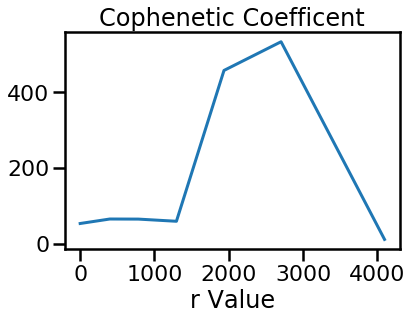

In [25]:
plt.plot(r_vals,cophenets)
plt.title('Cophenetic Coefficent')
plt.xlabel('r Value')
plt.show()

Although the curve starts decreasing at $r=2704$, the main break occurs at $r=1936$. The ideal value of r is thus contained between those two values. We decide to use $r=48^{2}=2116$ in the future.

*Remark:* Firstly, we would have wanted to lead a more in-depth analysis of the cophenetic coefficient in order to make a more precise inference on the ideal value of $r$. Unfortunately, the algorithm is too computationaly costly to test on more models. \
Secondly, talking about 'an ideal value of $r$' does not make complete practical sense in our compression problem. Indeed, though it can be interpreted as the least value before there is a significant loss of information, compression problems often appear in cases where memory space is the limiting factor (e.g. sending images by email). In these cases, the compression factor is given by the limitant factor of the task (in the email case it is the maximum size at which the image can be sent).

### Second application

Import the 20newsgroups dataset (from sklearn.datasets import fetch_20newsgroups_vectorized) that contains a collection of ~18,000 newsgroup documents from 20 different newsgroups.

Model the topics present in a subsample with *scikit-learn's* NMF. Print the most common words of each topic. 

Discuss.

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20


def print_top_words(D, feature_names, n_top_words):
    p, r = D.shape
    for topic_idx in range(r):
        topic = D[:, topic_idx]
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data[:n_samples]


# Use tf-idf features for NMF.
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data_samples)

# Fit the NMF model, print top words
# TODO

In [39]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [40]:
from sklearn.decomposition import NMF

In [41]:
nmf = NMF(n_components=n_components, init='random',random_state=0)
W = nmf.fit_transform(tfidf)

In [42]:
W.shape

(2000, 10)

In [43]:
print_top_words(nmf.components_.T, tfidf_feature_names, n_top_words)

Topic #0: just think like don game ll got team way good ve sure really year better thought win didn pretty play
Topic #1: people law did government say israel don know time make right rights think said evidence state let point case gun
Topic #2: thanks know does mail advance hi info interested anybody email looking like help appreciated card list send information need post
Topic #3: drive drives hard disk card software floppy mac pc power apple scsi computer controller problem memory board monitor mb speed
Topic #4: windows file dos using use program window files problem help os application running drivers version screen ms ftp available work
Topic #5: edu soon com send university internet ftp mail mit information article pub cc mac address hope email blood program contact
Topic #6: key chip clipper keys encryption use government public secure phone enforcement nsa data going doesn law communications used security encrypted
Topic #7: bike good right insurance course buy recommend dog c

In [44]:
new_data_sample = dataset.data[2036]  # unseen
print(new_data_sample)


Didn't Paul write that if the Resurrection is not true, we are the
biggest fools of all?  However, whether you believe in Christ or not,
His teachings (e.g. love your brotherman as yourself), even if only 
followed at a secular level, could do a great deal to alleviate some of 
the problems we see today in the world.  Even when I was a rabid atheist 
I couldn't deny that.


With which topics does the nmf model best associate this new sample? Does it make sense? What about another new sample?

In [55]:
# Vectorize new sample
new_samp_tfidf = tfidf_vectorizer.transform([new_data_sample])
new_samp_tfidf.shape

(1, 1000)

In [67]:
# Make prediction on new sample
prediction = nmf.transform(new_samp_tfidf)

In [69]:
# Get topic to which model associates the new 
np.argmax(prediction)

1

Model predicts new sample belongs to Topic 1 which mentions Isreal, law, states, law and rights. Nevertheless, it is visually clear that the new sample, which discusses christianism, belongs quite strongly to Topic 10.

Let us test the model on more samples in order to make inferences on the model's prediction power.

We randomly select 20 samples of the unseen data from which we will determine an approximation of the accuracy. Evidently, this test lacks precision and would require precise labelling of the remaining data in order to operate larger scale prediction analysis.

In [84]:
len(dataset.data)

11314

In [85]:
test_batch = np.random.randint(2000,11314,size=20)

In [86]:
new_data_sample = [dataset.data[i] for i in test_batch]

In [87]:
new_samp_tfidf = tfidf_vectorizer.transform(new_data_sample)
new_samp_tfidf.shape

(20, 1000)

In [88]:
# Make prediction on new sample
prediction = nmf.transform(new_samp_tfidf)

We estimate each documents' topic and use it as ground truth labelling. Documents with a topic not dealt with in the training takes value 10.

In [90]:
# Get topic to which model associates the new 
topic_pred = np.argmax(prediction, axis=1)

In [98]:
topic_true = np.array([3,2,10,4,10,3,10,4,10,10,1,10,0,10,1,10,10,10,10,4])

In [99]:
for i in range(topic_pred.shape[0]):
    print('Text {} - Prediced Topic {}'.format(i,topic_pred[i]))
    print(new_data_sample[i])

Text 0 - Prediced Topic 3
Many thanks to those who replied to my appeal for info on a drive I have
which is 3.5" 600RPM!!

I now have some information on how to modify this for use with a BBC B 
computer. Not only do you have to change the speed from 600 to 300 rpm
(tried that) but also change 8 components in the Rec/Play section to allow
for the lower data rate (250kbit, not 500kbit as it was designed for) and also
change the Recording Current to allow for the low data rate/rev speed!

Hopefully this should sort it all out .... not bad for 9 quid (normally 32 
quid and upwards ....)

The drive is a JVC MDP series drive ...
Text 1 - Prediced Topic 5
Quoting jgfoot@minerva.cis.yale.edu in article <1r3jgbINN35i@eli.CS.YALE.EDU>:

Text 2 - Prediced Topic 0
  (drieux, just drieux) writes (about the armed services):

Well, uh, actually I agree.


Text 3 - Prediced Topic 1


And you know why this is? Because you've conveniently _defined_ a theist as
someone who can do no wrong, and you've _d

In [100]:
from sklearn.metrics import accuracy_score

In [101]:
accuracy_score(topic_true, topic_pred)

0.15

As explained previously, this result should be taken lightly as it is in no way precise enough. In any case, it gives a good indication of how poorly our model is able to infere on new data.

Indeed, the model was trained on an extremely small set of documents which seem to have an important diversity in topics. It is unable to generalize especially because it is designed to make inferences on the training set and reduce its dimensionality. We can only expect its accuracy to be very low on types of data it has never seen (like any other ML model).

If we were to expect it to generalize correctly, we would require a large training dataset diverse and lawful to the aspect of data it will need to make inferences on in the future. For instance, we would expect the first model we trained on portraits to generalize better on other face images. Indeed, though the training data was fairly small, the scope of images it needs to make inferences on small as well. 

Unfortunately, I have not yet worked on NLP models and am unable to propose an critical opinion on the subject.